In [3]:
# Dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import requests
from census import Census
import gmaps
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as ex
#import plotly.graph_objects as go
from collections import Counter
#import WordCloud
#import STOPWORDS

# Census & gmaps API Keys
from config import (api_key, gkey)


# Configure gmaps
gmaps.configure(api_key=gkey)


In [4]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
c = Census(api_key, year=2019)

In [6]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name", "state": "State"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["Unemployment Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["State", "Name", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate", "Unemployment Rate"]]

census_pd.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate
0,01,Alabama,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,2.708946
1,02,Alaska,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,3.637114
2,04,Arizona,7050299.0,37.7,58945.0,30694.0,1043764.0,14.804535,2.778676
3,05,Arkansas,2999370.0,38.1,47597.0,26577.0,496260.0,16.545475,2.349860
4,06,California,39283497.0,36.5,75235.0,36955.0,5149742.0,13.109174,3.052765


In [7]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data_states.csv", encoding="utf-8", index=False)

In [8]:

census_df=pd.read_csv("census_data_states.csv")
census_df.dtypes


State                  int64
Name                  object
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Count        float64
Poverty Rate         float64
Unemployment Rate    float64
dtype: object

In [10]:
#reading airbnd data and census data
#df=pd.read_csv("/kaggle/input/us-airbnb-open-data/AB_US_2020.csv")
df=pd.read_csv("AB_US_2020.csv")
#df.dtypes


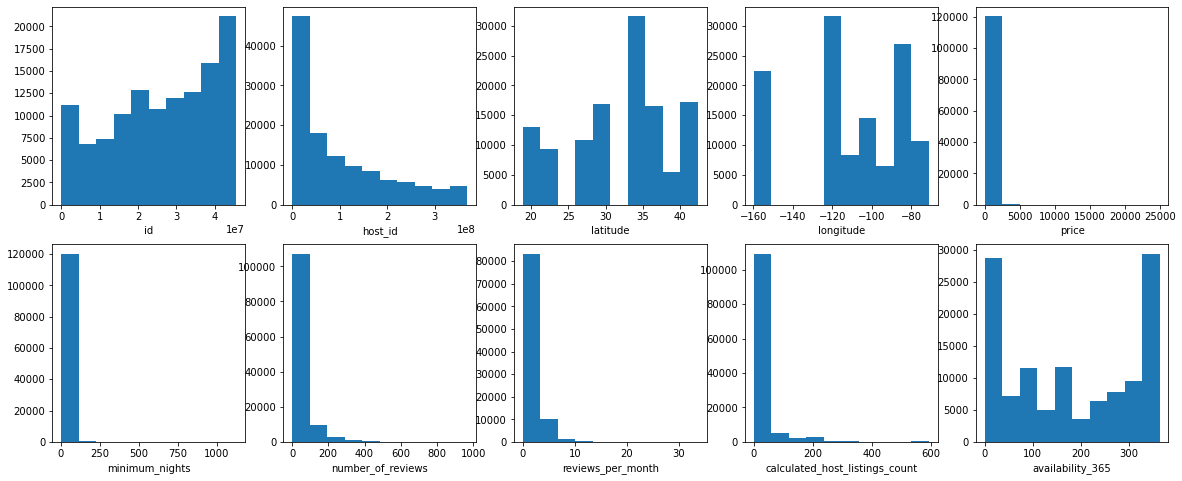

In [11]:
rows=2
cols=5
fig,ax=plt.subplots(rows,cols,figsize=(20,8))
d=df.select_dtypes(include=['float64','int64']).columns
for row in range(rows):
    for col in range(cols):
        ax[row,col].hist(df[d[cols*row+col]])
        ax[row,col].set_xlabel(d[cols*row+col])
plt.show() 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

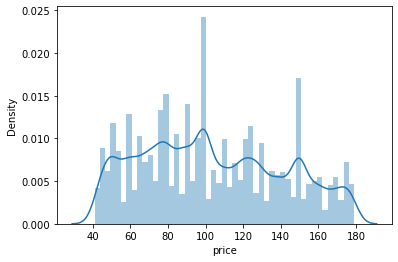

In [13]:
#Outlier removal
sns.distplot(df[(df['price']<180) & (df['price']>40)]['price'])
             #,kde=False,bins=10)

In [14]:
df=df[(df['price']<180) & (df['price']>40)]
len(df)

73249

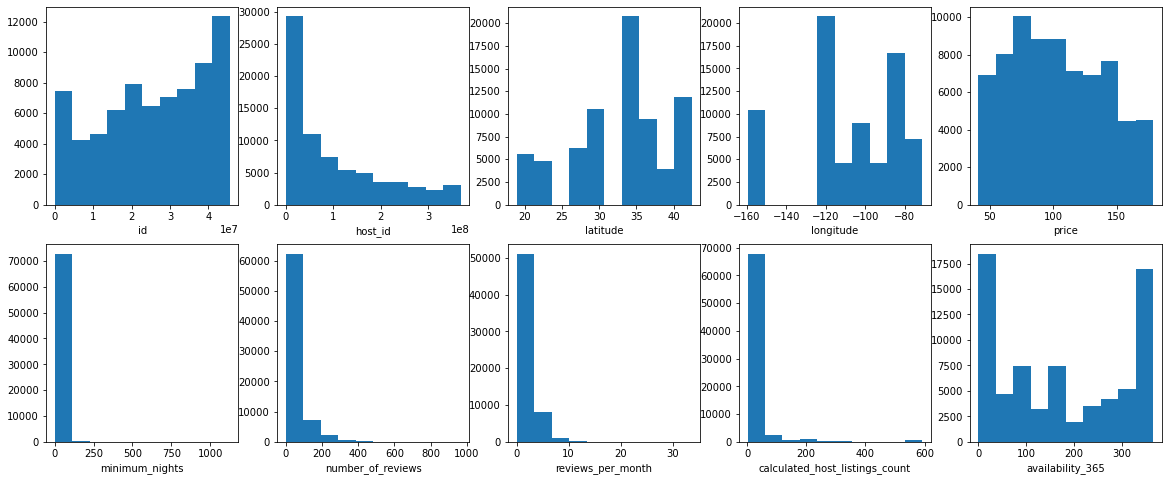

In [15]:
#There are still enough listings for us to train a model and predict the prices.
rows=2
cols=5
fig,ax=plt.subplots(rows,cols,figsize=(20,8))
d=df.select_dtypes(include=['float64','int64']).columns
for row in range(rows):
    for col in range(cols):
        ax[row,col].hist(df[d[cols*row+col]])
        ax[row,col].set_xlabel(d[cols*row+col])
plt.show() 

In [16]:
#Now the price values are much more evenly distributed and hence we can get fair predictions from our model.
city=df.groupby('city').agg({'id':'count','price':np.mean,'number_of_reviews':['sum',np.mean],'availability_365':np.mean})
city.head()

id       price number_of_reviews            availability_365
               count        mean               sum       mean             mean
city                                                                          
Asheville       1436  103.184540          135234.0  94.174095       151.314763
Austin          5908  101.349695          232927.0  39.425694       133.937204
Boston          2205  107.411338           93507.0  42.406803       179.898413
Broward County  6306  101.910561          164041.0  26.013479       189.875198
Cambridge        706  104.787535           34990.0  49.560907       135.339943